# Sample Fits

The notebook provides fits for the STM5050 data and the full resistance Biologic test cell

In [46]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib widget
from copy import deepcopy
from pathlib import Path

import hybdrt
from hybdrt.models import DRT
import hybdrt.fileload as fl
import hybdrt.plotting as hplt
import hybdrt.preprocessing as pp
from hybdrt.evaluation import DrtScorer, calculate_reg_metrics
from hybdrt.evaluation import chi_sq as chi_sq_score
import pandas as pd
from hybdrt.fileload import read_chrono, read_eis, get_hybrid_tuple
from pathlib import Path


import fig_funcs as ff

In [47]:
# Set tau limits for DOP normalization
# Registers the frequency range of interest and converts it to bounds for the time domain. 
# This sets the time scale used to normalize and interpret the DOP's constant-phase behavior alongside the DRT's ideal responses.
norm_tau = (1 / (2 * np.pi * 1e5), 1 / (2 * np.pi * 1e-2))

# Set DOP regularization strength (10:1 DRT:DOP ratio)
# Sets a parameter that makes the DOP inversion 10 times more regularized than the DRT inversion.attribute_categories,
# meaning it forces the DOP results to be smoother and less sensitive to noise compared to the DRT.
dop_l2_lambda_0 = 10

# Hybrid‐fit parameters
hy_fit_kw = dict(
    downsample=True,
    downsample_kw={
        'decimation_factor': 1.5,
        'method': 'decimate',
        'target_size': 1000,
        'antialiased': True
    },
    nonneg=True,
    iw_l2_lambda_0=1e-6,
    vz_offset=False,
    dop_l2_lambda_0=dop_l2_lambda_0
)


# Biologic Test Cell Fit

In [48]:
# Update datadir if you place the unzipped data archives in a different location. This sets the base directory.
datadir_test_cell = Path('../data/TESTCELL')

In [49]:
# Instantiate DRT objects
eis_drt = DRT(fit_dop=True,
              fixed_basis_tau=np.logspace(-7, 2, 91))
hy_drt = deepcopy(eis_drt)

geo_cp_file = datadir_test_cell.joinpath('testcell_v8_halfR_CP_04_10_25.txt')
geo_eis_file = datadir_test_cell.joinpath('testcell_v8_halfR_PEIS_04_10_25.txt')

# Read into DataFrames
cp_df  = fl.read_chrono(str(geo_cp_file), source="biologic")
eis_df = fl.read_eis(str(geo_eis_file), source="biologic")


# Extract data tuple (chrono + high‑freq EIS)
times, i_sig, v_sig, freq, z_eis = fl.get_hybrid_tuple(
    cp_df, eis_df,
    append_eis_iv=False,
    start_time=-0.1,
    min_freq=99
)

# Fit the hybrid DRT+DOP model
hy_drt.fit_hybrid(times, i_sig, v_sig, freq, z_eis, **hy_fit_kw)
 
# Build a dense frequency grid that extends to low frequencies
f_min_plot = 1e-3            # e.g. down to 1 mHz
f_max_plot = np.max(freq)
f_plot     = np.logspace(np.log10(f_min_plot), np.log10(f_max_plot), 300)
z_plot     = hy_drt.predict_z(f_plot)

Generating impedance integral lookups...
Generating response integral lookups...
Integral lookups ready


/Users/wwang/Documents/GitHub/joule_echem-mapping_2024/hybrid-drt_240425/hybdrt/models/drt1d.py:982: UserWarning: Solution did not converge within 50 iterations
  warnings.warn(f'Solution did not converge within {max_iter} iterations')


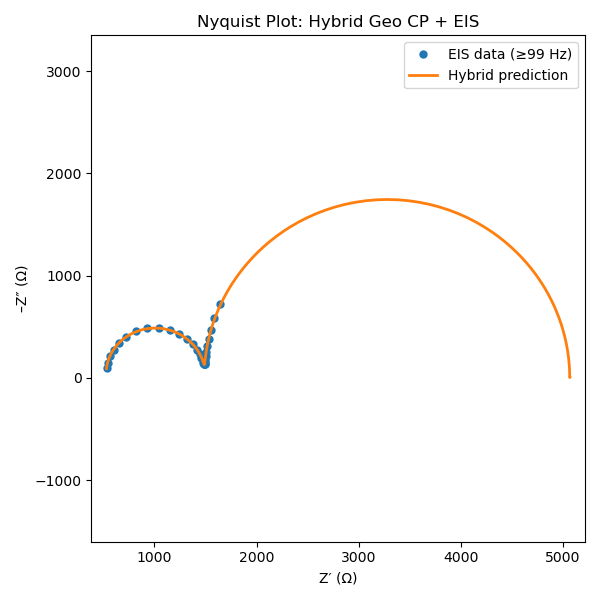

In [50]:
# 8) Plot
plt.figure(figsize=(6,6))
# raw high-frequency points
plt.plot(z_eis.real,   -z_eis.imag,   'o', ms=5, label='EIS data (≥99 Hz)')
# hybrid-predicted full range
plt.plot(z_plot.real,  -z_plot.imag, '-',  lw=2, label='Hybrid prediction')
plt.xlabel("Z′ (Ω)")
plt.ylabel("–Z″ (Ω)")
plt.title("Nyquist Plot: Hybrid Geo CP + EIS")
plt.axis('equal')
plt.legend()
plt.tight_layout()
plt.show()

# STM5050 Fit

In [51]:
# Update datadir if you place the unzipped data archives in a different location. This sets the base directory.
datadir_STM5050 = Path('../data/JINWOOK')

In [52]:
# 1) Instantiate DRT objects
eis_drt = DRT(fit_dop=True,
              fixed_basis_tau=np.logspace(-7, 2, 91))
hy_drt  = deepcopy(eis_drt)

geo_cp_file  = datadir_STM5050.joinpath('[1] 600C OCV_02_CP_C01.txt')
geo_eis_file = datadir_STM5050.joinpath('[1] 600C OCV_01_PEIS_C01.txt')
raw_eis_file = datadir_STM5050.joinpath('[1] 600C_C01(real data).txt')

# 3) Read into DataFrames
cp_df = fl.read_chrono(str(geo_cp_file), source="biologic")
eis_df = fl.read_eis(str(geo_eis_file), source="biologic")
raw_eis_df = fl.read_eis(str(raw_eis_file), source="biologic")

# Extract raw‐EIS complex impedance
if {'Zreal', 'Zimag'}.issubset(raw_eis_df.columns):
    z_raw = raw_eis_df['Zreal'].values+1j*raw_eis_df['Zimag'].values
else:
    raise ValueError("Impedance columns not found in raw_eis_df")

#Extract data tuple (chrono + high-freq EIS)
times, i_sig, v_sig, freq, z_eis = fl.get_hybrid_tuple(
    cp_df, eis_df,
    append_eis_iv=False,
    start_time=-0.1,
    min_freq=99
)

# Fit the hybrid DRT+DOP model
hy_drt.fit_hybrid(times, i_sig, v_sig, freq, z_eis, **hy_fit_kw)

# Build a dense frequency grid that extends to low frequencies
f_min_plot = 1e-3            # e.g. down to 1 mHz
f_max_plot = np.max(freq)
f_plot     = np.logspace(np.log10(f_min_plot), np.log10(f_max_plot), 300)
z_plot     = hy_drt.predict_z(f_plot)


Generating impedance integral lookups...
Generating response integral lookups...
Integral lookups ready


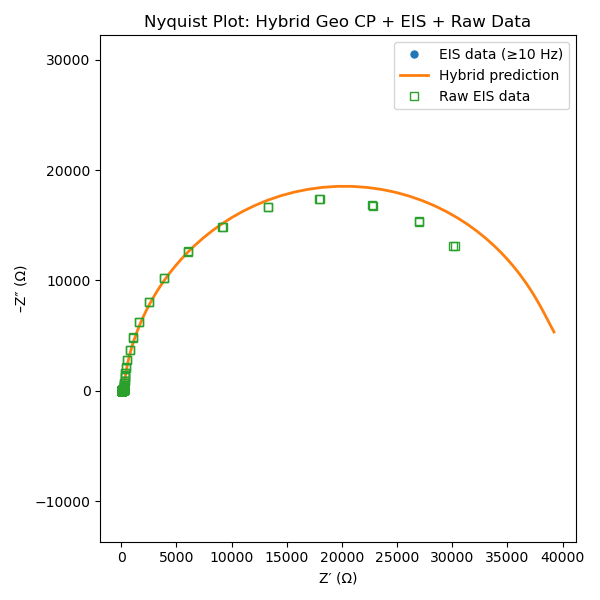

In [53]:
plt.figure(figsize=(6,6))
plt.plot(z_eis.real, -z_eis.imag,'o', ms=5,  label='EIS data (≥10 Hz)')
plt.plot(z_plot.real,-z_plot.imag,'-',  lw=2,  label='Hybrid prediction')
plt.plot(z_raw.real, -z_raw.imag,'s',  ms=6, mfc='none',
         label='Raw EIS data')

plt.xlabel("Z′ (Ω)")
plt.ylabel("–Z″ (Ω)")
plt.title("Nyquist Plot: Hybrid Geo CP + EIS + Raw Data")
plt.axis('equal')
plt.legend()
plt.tight_layout()
plt.show()

## Export Impedance Data to CSV

In [54]:
# Export hybrid‐fit results to CSV
df = pd.DataFrame({
    'frequency_Hz': f_plot,
    'Zreal_Ohms':   z_plot.real,
    'Zimag_Ohms':   z_plot.imag
})

df.to_csv('Jinwook_Hybrid_Data_4_23', index=False)